## 1. Setup

### 1.1 Install dependencies

In [96]:
!pip install -U -q torch torchvision matplotlib tqdm gdown

### 1.2 Check if GPU available

In [97]:
import torch

print(torch.cuda.is_available())

False


## 2. Load data 

Meta data are stored in a json file. Read the Json file and check entries of the first two samples.

In [98]:
import json

json_file_path = 'Dataset/dataset_label.json'

with open(json_file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

### 2.1 Inspect meta data

#### 2.1.1 Inspect single labels

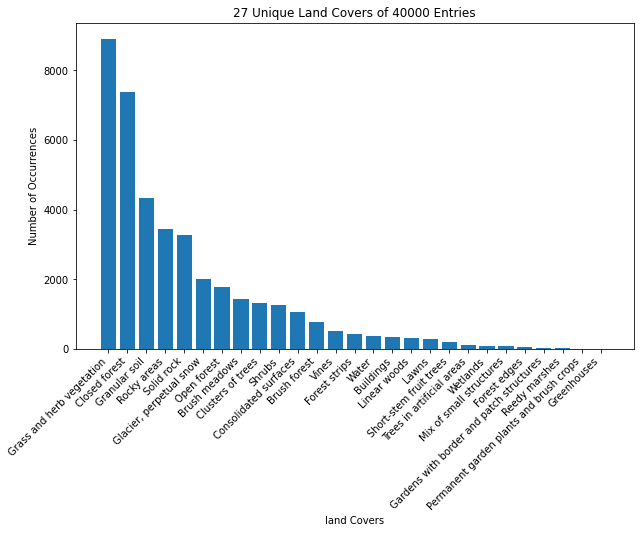

In [99]:
import matplotlib.pyplot as plt
from collections import Counter

landcover_texts = [entry["landcover_text"] for entry in data]# if entry.get("split") == "val"])

entry_counts = Counter(landcover_texts)
entry_counts_sorted = sorted_counts = dict(sorted(entry_counts.items(), key=lambda item: item[1], reverse=True))


plt.figure(figsize=(10, 6))
plt.bar(list(entry_counts_sorted.keys()), list(entry_counts_sorted.values()))
plt.xticks(rotation=45, ha='right')
plt.xlabel('land Covers')
plt.ylabel('Number of Occurrences')
plt.title(f"{len(entry_counts)} Unique Land Covers of {len(landcover_texts)} Entries")
plt.show()




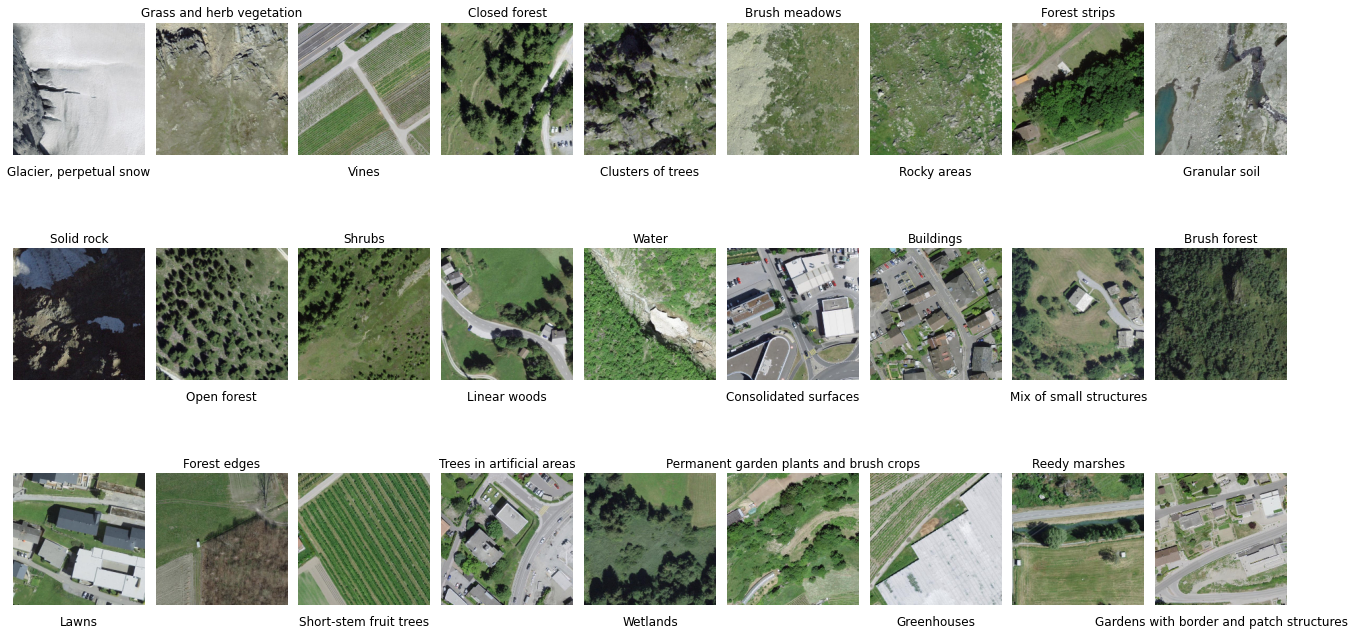

In [100]:
import os

# Preview a sample for each label using the fist encounter with the label

# Dictionary to store all first encounters of "landcover_text" with corresponding "rgb_path"
first_encounters = []

# Set to track unique "landcover_text" values
unique_landcover_texts = set()

for entry in data:
    landcover_text = entry["landcover_text"]
    if landcover_text not in unique_landcover_texts:
        unique_landcover_texts.add(landcover_text)
        first_encounters.append({"landcover_text": landcover_text, "rgb_path": entry["rgb_path"]})


# Create a subplot grid with 3 rows and 9 columns
fig, axs = plt.subplots(3, 9, figsize=(18, 10))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Iterate through both first_encounters and axs simultaneously
counter = 0
for encounter, ax in zip(first_encounters, axs):
    counter = counter + 1
    # Read the image
    img = plt.imread(os.path.join('Dataset/rgb/', encounter["rgb_path"]))

    # Display the image
    ax.imshow(img)

    if(counter % 2): # If the landcover_text is too long, put the title below the image
        ax.set_title(encounter["landcover_text"], y = -0.2)
    else: # Otherwise, put the title above the image
        ax.set_title(encounter["landcover_text"])

    # Hide axes ticks and labels for better visualization
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

#### 2.1.2 Inspect multi labels

In [101]:
# TODO

data[4]["landcover_ids"]

47

#### 2.1.3 Inspect train, validation and test splits

In [102]:
# Summary of the splits
total_entries = len(data)
train_entries = sum(entry.get("split") == "train" for entry in data)
val_entries = sum(entry.get("split") == "val" for entry in data)
test_entries = sum(entry.get("split") == "test" for entry in data)

print(f"Total entries: {total_entries}")
print(f"Entries with 'split': 'train': {train_entries} {train_entries/total_entries*100:.2f}%")
print(f"Entries with 'split': 'val': {val_entries} {val_entries/total_entries*100:.2f}%")
print(f"Entries with 'split': 'test': {test_entries} {test_entries/total_entries*100:.2f}%")

Total entries: 40000
Entries with 'split': 'train': 24000 60.00%
Entries with 'split': 'val': 4000 10.00%
Entries with 'split': 'test': 12000 30.00%


In [103]:
import pandas as pd
import plotly.express as px
df = pd.DataFrame(data)

from statsmodels.graphics.mosaicplot import mosaic

subset_df = (
    df[['landcover_text', 'split']]
    .groupby(['split', 'landcover_text'])
    .size()
    .reset_index(name='count')
)

# Calculate proportions
subset_df['proportion'] = subset_df.groupby('split')['count'].transform(lambda x: x / x.sum() * 100)

# Create a bar plot using plotly express
fig = px.bar(subset_df, x='landcover_text', y='proportion', color='split',
             title='Data splits appear to be well balanced per landcover class',
             labels={'landcover_text': 'Landcover Text', 'proportion': 'Proportion (%)'},
             category_orders={'split': sorted(subset_df['split'].unique())})

# Show the plot
fig.show()


### 2.2 Write a PyTorch Dataset Class

In [104]:
from torch.utils.data import Dataset

from PIL import Image

import glob

import numpy as np

class Valais(Dataset):
    # Labels for Land cover (NOLC04) - Federal Statistical Office | Data provided in 'Valais Dataset/landcover_labels.txt' switched to labels starting from 0 for compatibility
    LAND_COVER_MAPPING = {
    "Consolidated surfaces": 0,
    "Buildings": 1,
    "Greenhouses": 2,
    "Gardens with border and patch structures": 3,
    "Lawns": 4,
    "Trees in artificial areas": 5,
    "Mix of small structures": 6,
    "Grass and herb vegetation": 7,
    "Shrubs": 8,
    "Brush meadows": 9,
    "Short-stem fruit trees": 10,
    "Vines": 11,
    "Permanent garden plants and brush crops": 12,
    #"Tree vegetation": 13, # Not in data set
    "Closed forest": 13,
    "Forest edges": 14,
    "Forest strips": 15,
    "Open forest": 16,
    "Brush forest": 17,
    "Linear woods": 18,
    "Clusters of trees": 19,
    # "Bare land": 21, # Not in data set
    "Solid rock": 20,
    "Granular soil": 21,
    "Rocky areas": 22,
    # "Watery areas": 25, # Not in data set
    "Water": 23,
    "Glacier, perpetual snow": 24,
    "Wetlands": 25,
    "Reedy marshes": 26
}
    
    # Labels from Swiss Topographic Landscape Model (TLM) from Swisstopo | Data provided in 'Valais Dataset/multilabel_classes.txt'
    MULTI_LABEL_Mapping = {
    "background": 0,
    "agricultural area": 1,
    "building": 2,
    "bush forest": 3,
    "forest": 4,
    "glacier": 5,
    "lake": 6,
    "pedestrian path": 7,
    "public leisure area": 8,
    "railways": 9,
    "river": 10,
    "road": 11,
    "rocks": 12,
    "sparse forest": 13,
    "sparse rocks": 14,
    "swamps": 15,
    "vineyards": 16
}

    
    # Not necessary are images are labelled to be val, test or train
    # np.random.seed(9)
    # data_size = 10 # Number of images to be used for training, validation and testing
    # train_size = int(5/8 * data_size)
    # val_size = int(1/8 * data_size)
    
    # train_indices = np.random.choice(range(data_size), size=train_size, replace=False)
    # val_indices = np.random.choice(np.setdiff1d(range(data_size), train_indices), size = val_size, replace=False)
    # test_indices = np.setdiff1d(range(data_size), np.concatenate((train_indices, val_indices)))

    train_indices = [index for index, entry in enumerate(data) if entry.get("split") == "train"]
    val_indices = [index for index, entry in enumerate(data) if entry.get("split") == "val"]
    test_indices = [index for index, entry in enumerate(data) if entry.get("split") == "test"]

    SPLITS = {
        "train": train_indices,
        "val": val_indices,
        "test": test_indices
    }

    def __init__(self, split="train", transforms=None):
        self.transforms = transforms

        self.data = []  # list of tuples of (image path, label class)
        for labelclass in self.LAND_COVER_MAPPING:
            # get images with correct index according to dataset split
            for imgIndex in self.SPLITS[split]:
                imgName = data[imgIndex]["rgb_path"]
                imgLabel = data[imgIndex]["landcover_text"]
                # example format: 'baseFolder/agricultural/agricultural07.tif'
                self.data.append((
                    imgName,
                    self.LAND_COVER_MAPPING[imgLabel]          # get index for label class
                ))

    def __len__(self):
        return len(self.data)
    

    def __getitem__(self, index):
        # TODO retrieve the item from self.data at position index
        imgName, label = self.data[index]

        # TODO load the image array from the imgName
        img = Image.open(os.path.join('Dataset/rgb/',imgName)).convert('RGB')

        # TODO apply transformation
        if self.transforms is not None:
            img = self.transforms(img)
        return img, label

    


#### 2.2.1 Check if dataset class works

In [105]:
import matplotlib.pyplot as plt

# initialize the dataset (call the constructor __init__)
dataset = Valais()
print(f"dataset of length {len(dataset)}")

# plot individual samples
from ipywidgets import interact
# @interact(idx=range(len(dataset))) # Too big causing crash
@interact(idx=range(100))
def plot_sample(idx=0):
    img, label = dataset[idx]

    plt.imshow(img)

    # swaps keys and values in the dictionary UCMerced.LABEL_CLASSES
    class_mapping = {v: k for k, v in Valais.LAND_COVER_MAPPING.items()}

    plt.title(f"classid {label} ({class_mapping[label]})")

dataset of length 648000


interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

### 2.3 Define custom transforms

In [106]:
# import os
# from PIL import Image
# import torch
# from torchvision import transforms

# # Define your dataset path and transform without normalization
# dataset_path = 'Valais Dataset/rgb/'
# transform = transforms.Compose([transforms.ToTensor()])

# # Get a list of image file paths
# image_paths = [os.path.join(dataset_path, img) for img in os.listdir(dataset_path) if img.endswith(('.tif'))]

# # Initialize variables to accumulate the sum and sum of squares
# mean_sum = torch.zeros(3)
# std_sum = torch.zeros(3)

# # Loop through the images and compute the sum and sum of squares
# for img_path in image_paths:
#     img = Image.open(img_path)
#     img = transform(img)
#     mean_sum += img.mean(dim=[1, 2])
#     std_sum += img.std(dim=[1, 2])

# # Calculate the mean and standard deviation
# mean = mean_sum / len(image_paths)
# std = std_sum / len(image_paths)

# print("Calculated mean:", mean)
# print("Calculated std:", std)


In [107]:
import torchvision.transforms as T
import numpy as np

# mean and standard deviation of the dataset
mean=torch.tensor([0.4215, 0.4603, 0.3775])
std=torch.tensor([0.1379, 0.1375, 0.1301])

# normalize image [0-1] (or 0-255) to zero-mean unit standard deviation
normalize = T.Normalize(mean, std)
# we invert normalization for plotting later
std_inv = 1 / (std + 1e-7)
unnormalize = T.Normalize(-mean * std_inv, std_inv)

transforms_train = T.Compose([
    T.RandomResizedCrop((180, 180)), # Original size is 200x200
    T.RandomGrayscale(p=0.1),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    T.RandomPosterize(bits=4, p=0.2),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),

  T.Resize((200, 200)),
  T.ToTensor(),
  normalize
])

# we do not augment the validation dataset (aside from resizing and tensor casting)
transforms_val = T.Compose([
  #T.Resize((200, 200)), # No need they are 200 x 200 anyways
  T.ToTensor(),
  normalize
])

#### 2.3.1 Check if transforms work

[(-0.5, 199.5, 199.5, -0.5), (-0.5, 199.5, 199.5, -0.5)]

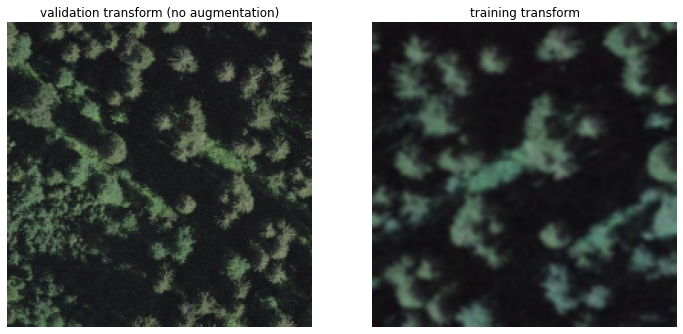

In [108]:
dataset_index = 320

img, label = dataset[dataset_index]

fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].imshow(unnormalize(transforms_val(img)).permute(1,2,0))
axs[0].set_title("validation transform (no augmentation)")

axs[1].imshow(unnormalize(transforms_train(img)).permute(1,2,0))
axs[1].set_title("training transform")
[ax.axis("off") for ax in axs] # removes ticks

### 2.3 Create train and validation data loaders

In [109]:
train_dataset = Valais(split = 'train' , transforms=transforms_train)
val_dataset = Valais(split = 'val', transforms=transforms_val)

In [110]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_dataset , batch_size=16, shuffle=True, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, prefetch_factor=None,
           persistent_workers=False)

val_dl = DataLoader(val_dataset , batch_size=16, shuffle=True, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, prefetch_factor=None,
           persistent_workers=False)

In [111]:
idx, batch = next(enumerate(train_dl))

# retrieve image and label from the batch
x, y = batch

print(y)

tensor([21, 21, 10,  7,  9,  7,  7,  7, 13, 21, 20,  9,  7, 17, 13,  7])


## 3. Train model

### 3.1 AlexNet Architecture

In [112]:
from torch import nn

class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super().__init__()

        ## features here do not mean X_1, X_2, ...etc. In a convolutional NN it's the set of operations, jumping from one layer to the
        ## next- Notice that that as we jump the # input parameters in = the #output parameters of prev layers.
        ## Notice also that as you jump we may increase or decrease the # output parameters as we see fit.
        self.features = nn.Sequential(
            # 11x11 convolution from 3 to 64 channels, stride 4, padding 2
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            # 3x3 Maxpool with stride 2
            nn.MaxPool2d(kernel_size=3, stride=2),

            # 5x5 convolution from 64 to 192 channels and padding 2
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            # 3x3 Maxpool with stride 2
            nn.MaxPool2d(kernel_size=3, stride=2),

            # 3x3 convolution from 192 to 384 channels and padding 1
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # 3x3 convolution from 384 to 256 channels and padding 1
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # 3x3 convolution from 256 to 256 channels and padding 1
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # 3x3 Maxpool with stride 2
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        ## Fully connected NN basically after all the CNN layers
        self.classifier = nn.Sequential(
            # Dropout
            nn.Dropout(dropout),
            # Linear with 256*6*6 to 4096 channels
            nn.Linear(in_features = 256*6*6, out_features =4096),
            # inplace ReLU
            nn.ReLU(inplace=True), #If false it creates a new tensor and stores the result there. Would not track for the forward pass.
            # Dropout
            nn.Dropout(dropout),
            # Linear with 4096 to 4096 channels
            nn.Linear(in_features = 4096, out_features = 4096),
            # inplace ReLU
            nn.ReLU(inplace=True),
            # Linear with 4096 to num_classes channels
            nn.Linear(in_features = 4096, out_features = num_classes)
        )### THIS ALL THE CONSTRUCTOR!!!!! CONSTRUCTOR DOES PREDICTION!!!!

    def forward(self, x: torch.Tensor) -> torch.Tensor: ### WOWWWWW This is functional PROGRAMMING!!!!!!!!!

        # Recall that in al the sequentials we intialised so to say the layers but we did not pass our feature tensor yet? Similar to the
        # code we wrote earlier in the above cells we would do convlayer = nn.conv2d(,,,,) and then do x=convlayer(x) now we have sqn!
        x = self.features(x)    # apply features sub-module
        x = self.avgpool(x)     # apply average pooling sub-module
        x = torch.flatten(x, 1) # <== ofcouse we need to have it as a vector to do Fully Connected NN :)
        x = self.classifier(x)  # apply classifier sub.module
        return x


# Notice this class does not have the methods predict or step, i.e it does not do any training!!
# THE CONSTRUCTOR HOWEVER DOES PREDICTION(ForwardPass) AUTOMATICALLY!! model = AlexNet(num_classes = XX) -> model(x) returns logits

In [113]:
# Load the model :
model = AlexNet(num_classes=27)

In [114]:

%pip install -q -U pytorch_lightning tensorboard
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

from pytorch_lightning.callbacks import ModelCheckpoint

import torch.nn as nn
import torch.nn.functional as F

class PLWrapper(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("val_loss", loss)
        self.log("val_accuracy", (y_hat.argmax(1) == y).float().mean())

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=0.01, weight_decay=0.01)


Note: you may need to restart the kernel to use updated packages.


In [115]:
plmodel = PLWrapper(model)

tb_logger = pl_loggers.TensorBoardLogger(save_dir="logs/")

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='alexnet-{epoch}-{val_accuracy:.2f}',
    monitor="val_accuracy",
    mode="max"
    )

trainer = pl.Trainer(max_epochs=3, accelerator="cpu",
                        logger=tb_logger, callbacks=[checkpoint_callback])#,
                        #resume_from_checkpoint="checkpoints/alexnet-epoch=987-val_accuracy=0.73.ckpt")

trainer.fit(plmodel, train_dataloaders=train_dl, val_dataloaders=val_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type    | Params
----------------------------------
0 | model | AlexNet | 57.1 M
----------------------------------
57.1 M    Trainable params
0         Non-trainable params
57.1 M    Total params
228.458   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\moham\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\moham\anaconda3\lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
